<a href="https://colab.research.google.com/github/SrMatheus2000/topicos-espaciais-gb/blob/main/GB_Topicos_espaciais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/drive/MyDrive/ast3.csv'  # Update with your file path
data = pd.read_csv(file_path, delimiter=';')

# Parameters for tokenization and padding
max_num_tokens = 10000  # We will keep only the top 10,000 tokens
max_seq_length = 500    # We will pad/truncate to 500 tokens

def tokenize_ast(ast_json):
    tokens = []

    def extract_tokens(node):
        if isinstance(node, dict):
            node_type = node.get('type')
            if node_type:
                tokens.append(node_type)
            for key, value in node.items():
                if key not in ['start', 'end', 'loc']:  # Skip position-based keys
                    extract_tokens(value)
        elif isinstance(node, list):
            for item in node:
                extract_tokens(item)

    extract_tokens(ast_json)
    return ' '.join(tokens)

# Tokenize the AST column
data['ast_tokens'] = data['ast'].apply(lambda x: tokenize_ast(json.loads(x)))

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=max_num_tokens, oov_token='<OOV>')
tokenizer.fit_on_texts(data['ast_tokens'])

# Convert the token strings to sequences of integers
sequences = tokenizer.texts_to_sequences(data['ast_tokens'])

# Pad the sequences so that they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# Prepare the labels
labels = data['vulnerable'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Model configuration
embedding_dim = 64  # Size of the embedding vectors
lstm_units = 64     # Number of units in the LSTM layer

# Define the BLSTM model
model = Sequential([
    Embedding(input_dim=max_num_tokens, output_dim=embedding_dim, input_length=max_seq_length),
    Bidirectional(LSTM(units=lstm_units)),
    Dense(1, activation='sigmoid')  # Since it's a binary classification problem
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 706177 (2.69 MB)
Trainable params: 706177 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import numpy as np

# Training configuration
batch_size = 32
epochs = 10

from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Calculate class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)



Epoch 1/10
64/64 [==============================] - 52s 721ms/step - loss: 0.6936 - accuracy: 0.5329 - val_loss: 0.7009 - val_accuracy: 0.4475
Epoch 2/10
64/64 [==============================] - 44s 682ms/step - loss: 0.6947 - accuracy: 0.4562 - val_loss: 0.6936 - val_accuracy: 0.4475
Epoch 3/10
64/64 [==============================] - 46s 730ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6889 - val_accuracy: 0.5604
Epoch 4/10
64/64 [==============================] - 44s 686ms/step - loss: 0.6930 - accuracy: 0.5215 - val_loss: 0.6912 - val_accuracy: 0.5604
Epoch 5/10
64/64 [==============================] - 45s 694ms/step - loss: 0.6923 - accuracy: 0.5394 - val_loss: 0.6931 - val_accuracy: 0.5109
Epoch 6/10
64/64 [==============================] - 47s 741ms/step - loss: 0.6929 - accuracy: 0.5191 - val_loss: 0.6946 - val_accuracy: 0.4257


16/16 [==============================] - 4s 227ms/step


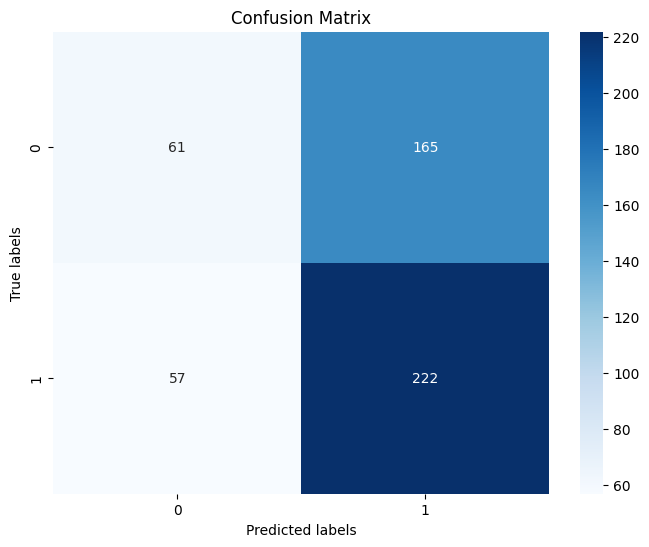

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.27      0.35       226
           1       0.57      0.80      0.67       279

    accuracy                           0.56       505
   macro avg       0.55      0.53      0.51       505
weighted avg       0.55      0.56      0.53       505



In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Threshold the predictions to get binary labels
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

In [ ]:
################################################### BERT ##########################################################

In [ ]:
!pip install transformers pandas
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch

In [ ]:
# Load the CSV file
file_path = '/content/drive/MyDrive/corpus.csv'  # Replace with your file path
df = pd.read_csv(file_path, delimiter=';')  # Replace delimiter if different

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base')

# Tokenize the function code for both training and testing sets
train_encodings = tokenizer(train_df['function'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_df['function'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Reset index to make sure indices form a continuous range
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

class FunctionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Create the training and testing datasets
train_dataset = FunctionDataset(train_encodings, train_df['vulnerable'])
test_dataset = FunctionDataset(test_encodings, test_df['vulnerable'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset  # Provide the testing dataset for evaluation
)

In [ ]:
# Train the model
trainer.train()

# Evaluate the model on the testing set
eval_results = trainer.evaluate()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_codebert')

# Print the evaluation results
print(eval_results)

In [ ]:
############################################# Finetuned BERT ##################################

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd


# Load the tokenizer and fine-tuned model
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/fine_tuned_codebert')


# Load the CSV file
file_path = '/content/drive/MyDrive/corpus.csv'  # Replace with your file path
df = pd.read_csv(file_path, delimiter=';')  # Replace delimiter if different

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the function code for both training and testing sets
train_encodings = tokenizer(train_df['function'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_df['function'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

# Reset index to make sure indices form a continuous range
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Create a dataset object
class FunctionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

# Create the training and testing datasets
train_dataset = FunctionDataset(train_encodings, train_df['vulnerable'])
test_dataset = FunctionDataset(test_encodings, test_df['vulnerable'])


In [ ]:




# Assuming that your test_dataset is already created and available


# Define the device
device = torch.device("cpu")
model.to(device)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions on the test set
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Process raw predictions
y_pred = np.argmax(raw_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_df['vulnerable'], y_pred)
print('Test Accuracy:', accuracy)

Test Accuracy: 0.5524752475247525


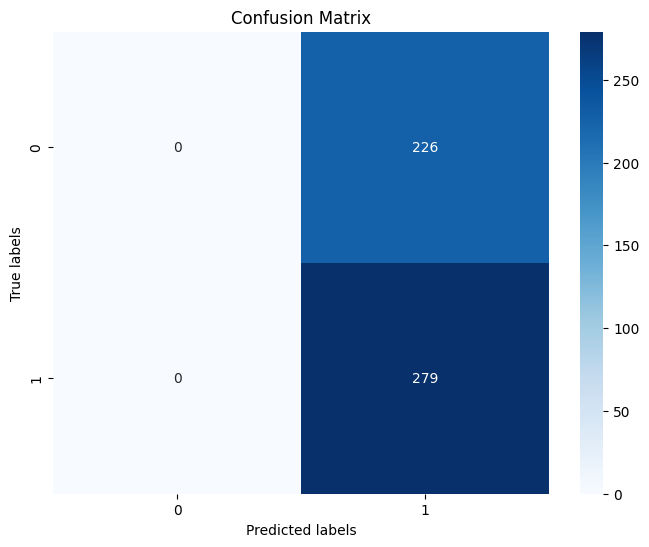

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.55      1.00      0.71       279

    accuracy                           0.55       505
   macro avg       0.28      0.50      0.36       505
weighted avg       0.31      0.55      0.39       505



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_pred (predicted labels) and test_df['vulnerable'] (true labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_df['vulnerable'], y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_df['vulnerable'], y_pred))
